## **Introduction to Convolutional NN**

## **Problem Statement:**
The task at hand involves classifying images of cats and dogs using a Convolutional Neural Network (CNN). We have a dataset containing images of cats and dogs and the objective is to train a CNN model to accurately predict the class of each image.

## **Objectives:**

In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  1


In [3]:
# Check GPU Availability and Configure TensorFlow Session
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Enable memory growth
    print("GPU is available and TensorFlow is using it.")
else:
    print("GPU is not available. Training will use CPU.")

GPU is available and TensorFlow is using it.


In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

## **Data Preparation:**
● Download and extract the cats vs. dogs dataset.

● Organize the dataset into a structured directory format suitable for TensorFlow’s ImageDataGenerator.

● Split the dataset into training and testing sets.

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp /content/sample_data/kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.06G/1.06G [00:04<00:00, 224MB/s]
100% 1.06G/1.06G [00:04<00:00, 241MB/s]


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.2,  # Randomly shear images
    zoom_range=0.2,  # Randomly zoom in/out
    horizontal_flip=True , # Randomly flip images horizontally
    fill_mode='nearest',# Fill in missing pixels with the nearest filled value
    rotation_range=15, # rotate the image 20 degrees
    width_shift_range=0.10, # Shift the pic width by a max of 5%
    height_shift_range=0.10, # Shift the pic height by a max of 5%
)

In [11]:
test_datagen = ImageDataGenerator(
    rescale=1./255)  # Normalize pixel values

## **Data Augmentation and Preprocessing:**
● Implement data augmentation techniques to increase the diversity of the training dataset, aiding in the model's ability to generalize.

● Normalize the pixel values of the images for optimal model performance.

In [12]:
# Apply augmentation to the training dataset
train_dataset = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'  # Adjust for multiple classes
)

# Apply augmentation for the test dataset
test_dataset = test_datagen.flow_from_directory(
    '/content/test',
    batch_size=32,
    target_size=(256, 256),
    shuffle=True,  # Adjust for multiple classes
    class_mode='categorical'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [13]:
print("train class:",train_dataset.class_indices)
print("test class:",test_dataset.class_indices)

train class: {'cats': 0, 'dogs': 1}
test class: {'cats': 0, 'dogs': 1}


In [14]:
print("train data shape:",train_dataset[0][0].shape)
print("test data shape:",test_dataset[0][0].shape)

train data shape: (32, 256, 256, 3)
test data shape: (32, 256, 256, 3)


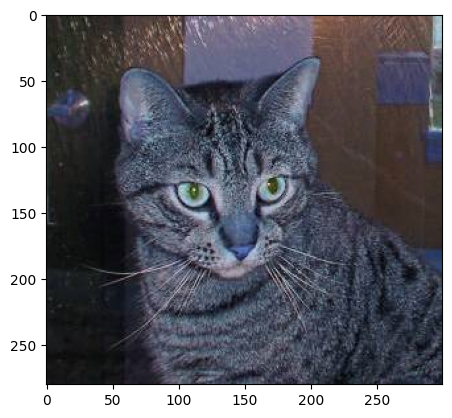

In [15]:
Image = cv2.imread( '/content/train/cats/cat.1.jpg')
plt.imshow(Image)

## **Model Building:**
● Construct a Convolutional Neural Network using TensorFlow and Keras.

● The model should contain multiple convolutional layers, pooling layers, and fully connected layers.

## **Training:**
● Compile the model and train it on the prepared dataset.

● Utilize categorical cross entropy as the loss function and stochastic gradient descent as the optimizer.

● Train the model for a sufficient number of epochs to achieve good performance.

In [16]:
# create CNN model

def DogCatmodel():
   model =tf.keras.Sequential([

      Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

      Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

      Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'),

      Flatten(),

      Dense(128,activation='relu'),
      Dropout(0.1),
      Dense(64,activation='relu'),
      Dropout(0.1),
      Dense(2,activation='sigmoid')])

   model.compile( optimizer=SGD(learning_rate=0.001),
                 loss='categorical_crossentropy',
                  metrics=['accuracy'])

   return model

In [17]:
model = DogCatmodel()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [19]:
Step_size_train=train_dataset.n//train_dataset.batch_size
Step_size_test=test_dataset.n//test_dataset.batch_size
print("Step_size_train:",Step_size_train)
print("Step_size_test:",Step_size_test)

Step_size_train: 625
Step_size_test: 156


In [21]:
# Early stopping with GPU
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # Adjust patience as needed

# Train the model with validation monitoring on GPU
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset,steps_per_epoch =Step_size_train,validation_steps=Step_size_test, callbacks=[early_stopping])

Epoch 1/10
625/625 [==============================] - 380s 596ms/step - loss: 0.6434 - accuracy: 0.6410 - val_loss: 0.5779 - val_accuracy: 0.6863
Epoch 2/10
625/625 [==============================] - 353s 565ms/step - loss: 0.5727 - accuracy: 0.6985 - val_loss: 0.5099 - val_accuracy: 0.7522
Epoch 3/10
625/625 [==============================] - 363s 582ms/step - loss: 0.5407 - accuracy: 0.7255 - val_loss: 0.5061 - val_accuracy: 0.7562
Epoch 4/10
625/625 [==============================] - 371s 593ms/step - loss: 0.5137 - accuracy: 0.7437 - val_loss: 0.4714 - val_accuracy: 0.7750
Epoch 5/10
625/625 [==============================] - 368s 589ms/step - loss: 0.5035 - accuracy: 0.7527 - val_loss: 0.5583 - val_accuracy: 0.7208
Epoch 6/10
625/625 [==============================] - 370s 593ms/step - loss: 0.4886 - accuracy: 0.7624 - val_loss: 0.4802 - val_accuracy: 0.7714
Epoch 7/10
625/625 [==============================] - 368s 589ms/step - loss: 0.4750 - accuracy: 0.7701 - val_loss: 0.4418 -

In [73]:
!nvidia-smi

Thu May  9 07:59:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              28W /  70W |   6273MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [23]:
model.metrics_names

['loss', 'accuracy']

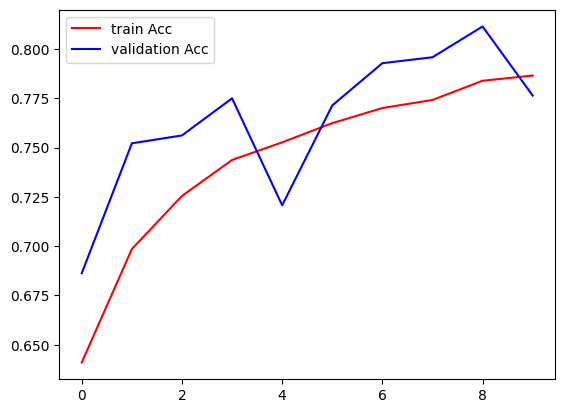

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train Acc')
plt.plot(history.history['val_accuracy'],color='blue',label='validation Acc')
plt.legend()
plt.show()

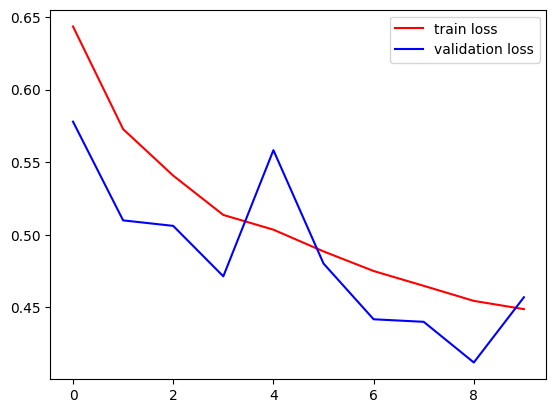

In [25]:
plt.plot(history.history['loss'],color='red',label='train loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.legend()
plt.show()

# **Evaluation:**

● Evaluate the model's performance on the validation set during training to
monitor for overfitting.

● After training, assess the model's accuracy and make predictions on the
test set.


In [74]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

157/157 [==============================] - 14s 86ms/step - loss: 0.4571 - accuracy: 0.7764
Test accuracy: 0.7764000296592712


In [27]:
test_image_gen = train_datagen.flow_from_directory('/content/test',
                                               target_size=[256,256],
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False,
                                                seed=42)

Found 5000 images belonging to 2 classes.


In [34]:
probabilities = model.predict(test_image_gen)
probabilities

157/157 [==============================] - 86s 548ms/step


array([[0.79423976, 0.6183898 ],
       [0.7177226 , 0.5830955 ],
       [0.381872  , 0.78203785],
       ...,
       [0.20243648, 0.5440808 ],
       [0.2526144 , 0.6191413 ],
       [0.3721935 , 0.38592997]], dtype=float32)

In [48]:
answers =test_image_gen.classes[2475:2525]
answers

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [49]:
predictions = probabilities > 0.5

In [50]:
predictions[2475:2525]

array([[ True, False],
       [False, False],
       [ True, False],
       [False, False],
       [ True,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [False, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False, False],
       [False,  True],
       [False,  True],
       [ True,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False, False],
       [False,  True],
       [Fal

## **Save Model**

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # Ignore the HDF5 warning
model.save('/content/drive/MyDrive/DogCatmodel1.h5')


In [60]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # Ignore the HDF5 warning
model.save('/content/DogCatmodel1.h5')


## **Prediction:**
● Implement a system to make predictions on new images, categorizing them as either cat or dog.

● The system should be able to take an image (or a batch of images), preprocess it, and pass it through the model for prediction.

In [63]:
# Define function to preprocess and predict on an image
def predict_cat_dog(img_path):
  # Load the pre-trained Keras model
  model = load_model('/content/DogCatmodel1.h5')

  # Load the image and pre-process it
  img = load_img(img_path, target_size=(256, 256))
  img_array = img_to_array(img)
  img_array = img_array / 255.0  # Normalize pixel values
  img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

  # Make predictions
  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions[0])
  class_names = ['cats', 'dogs']  # Assuming these are your class labels

  # Print the predicted class
  print(f"Image predicted as: {class_names[predicted_class]} with a probability of {predictions[0][predicted_class]:.2f}")



In [64]:
# replace with your image path
img_path = '/content/test/cats/cat.10109.jpg'
predict_cat_dog(img_path)


1/1 [==============================] - 0s 108ms/step
Image predicted as: cats with a probability of 0.77


In [65]:
# Function to preprocess an image
def preprocess_image(img_path, target_size=(256, 256)):
  img = load_img(img_path, target_size=target_size)
  img_array = img_to_array(img)
  img_array = img_array / 255.0  # Normalize pixel values
  print(f"Preprocessed image shape: {img_array.shape}")
  return img_array

# Function to predict on a single image or a batch of images
def predict_cat_dog(img_paths):
  # Load the pre-trained Keras model
  model = load_model('/content/DogCatmodel1.h5')

  # Preprocess images (single or batch)
  if isinstance(img_paths, str):  # Single image
    preprocessed_img = preprocess_image(img_paths)
  else:  # Batch of images
    preprocessed_images = np.array([preprocess_image(path) for path in img_paths])

  # Make predictions
  predictions = model.predict(preprocessed_img if isinstance(img_paths, str) else preprocessed_images)
  predicted_classes = np.argmax(predictions, axis=1)
  class_names = ['cats', 'dogs']  #  class labels

  # Print predictions
  if isinstance(img_paths, str):  # Single image
    print(f"Image predicted as: {class_names[predicted_classes[0]]} with a probability of {predictions[0][predicted_classes[0]]:.2f}")
  else:  # Batch of images
    for i, path in enumerate(img_paths):
      print(f"Image '{path}' predicted as: {class_names[predicted_classes[i]]} with a probability of {predictions[i][predicted_classes[i]]:.2f}")



In [66]:
# Batch of images (list of paths)
img_paths = [
    '/content/test/cats/cat.10109.jpg',
    '/content/test/dogs/dog.10109.jpg'
]
predict_cat_dog(img_paths)

Preprocessed image shape: (256, 256, 3)
Preprocessed image shape: (256, 256, 3)
1/1 [==============================] - 0s 433ms/step
Image '/content/test/cats/cat.10109.jpg' predicted as: cats with a probability of 0.77
Image '/content/test/dogs/dog.10109.jpg' predicted as: dogs with a probability of 0.79


# **Why Augmentation is Important:**

Here are some key reasons why data augmentation is crucial for deep learning models:

**Combats Overfitting:** Deep learning models are susceptible to overfitting, where they learn the training data too well, including its specific biases and noise. This can lead to poor performance on unseen data. Augmentation helps by introducing variations in the training data, forcing the model to learn more generalizable features that apply to a broader range of inputs.

**Increases Dataset Size:** Collecting large datasets can be expensive and time-consuming. Augmentation provides a cost-effective way to significantly increase the size of your training data. By creating new variations from existing samples, you provide the model with more information to learn from.

**Improves Model Robustness:** Real-world data often has variations like rotations, flips, changes in lighting, or slight occlusions. Augmentation helps the model learn to be robust to these variations. When the model sees an image that's slightly rotated or has a different brightness level compared to the training data, it's still able to make accurate predictions due to the diverse training it received through augmentation.

# **Common Augmentation Techniques:**

Here are some common types of data augmentation used in image classification:

**Geometric Transformations:** Rotating, flipping (horizontally/vertically), scaling, and shearing images.
**Color Space Augmentations:** Adjusting brightness, contrast, saturation, hue, and adding noise.
**Random Cropping:** Selecting random subsets of an image to train the model on different parts of the image.
Overall Benefits:

**By incorporating data augmentation into your deep learning workflow, you can achieve the following benefits:**

Improved model accuracy and generalization on unseen data.
Increased model robustness to variations in real-world data.
More efficient use of your existing training data.
Data augmentation is a simple yet powerful technique that can significantly enhance the performance and generalizability of your deep learning models.

# **train_datagen.flow_from_directory (Augmentation):**

This function expects the labels to be already present in the directory structure. It infers the labels based on subdirectory names.

labels='inferred' (default) is unnecessary here as it's the default behavior.

label_mode='int' is also not applicable because the labels are already assumed to be integers based on the subdirectory structure.

# **keras.utils.image_dataset_from_directory (No Augmentation):**

This function requires explicit label information as it doesn't infer labels from directory structure.

labels='inferred' is not useful here because there's no directory structure to infer from.

label_mode='int' is necessary to convert categorical labels (e.g., one-hot encoded) to integers, which is the expected format for the class_mode argument.
class_mode in Test Dataset:

## **class_mode='categorical' isn't working because keras.utils. **bold text**
image_dataset_from_directory assumes integer labels by default (without augmentation).
To use categorical labels, you'd likely need to provide them explicitly during dataset creation or convert them from one-hot encoded format to integers before using this function.
Here's a corrected version of your code that addresses these points:


# **Alternative for Test Dataset with Categorical Labels:**

If your test data uses categorical labels, consider these options:

Preprocess Labels: Convert your categorical labels to integers before using keras.utils.image_dataset_from_directory.

Custom Data Generator: Create a custom data generator that handles categorical labels.

**Remember:**

Use labels and label_mode in conjunction with keras.utils.image_dataset_from_directory for explicit label handling.
train_datagen.flow_from_directory infers labels from directory structure when augmentation is applied.
Choose the approach that aligns with your dataset's label format.

# **Benefits of Augmentation for Training Data:**

Increased dataset size: Augmentation generates variations of existing images, effectively multiplying the size of your training data. This helps the model learn from a wider range of variations and reduces overfitting.
Improved robustness: By seeing rotated, flipped, resized, color-adjusted versions of images, the model becomes more robust to real-world variations that might not be present in the original dataset.
Reasons to Avoid Augmentation on Test Data:

**Fair evaluation**: The test data should represent the real-world data the model will be applied to. Augmentation might introduce variations that aren't present in real-world scenarios, leading to an unrealistic evaluation of the model's performance.

**Unintended bias:** If the augmentation techniques introduce a specific bias that aligns with the training data's inherent bias, the model's performance on augmented test data might be misleadingly high.
Alternative: Test-Time Augmentation

There's an advanced technique called test-time augmentation (TTA). Here, you apply various augmentations to a single test image, creating multiple versions. The model's predictions on each augmented copy are then averaged or combined to get a final prediction. This can sometimes improve performance, especially when dealing with small test sets. However, TTA introduces additional computational cost and complexity, so it's not always necessary.

**Conclusion**

Using augmentation on training data and leaving the test data unaugmented is a common and effective approach. It helps improve training robustness while ensuring a fair evaluation of the model's performance on real-world data.

# **rescale: This variable name suggests it's a factor used to rescale the pixel values.**

1.: The numerator represents a scaling factor of 1.
/ 255: The denominator represents the original range of pixel values (typically 0 to 255).

**Normalization Process:**

Original Range: Most image formats store pixel values as integers between 0 (black) and 255 (white).

Rescaling: Dividing each pixel value by 255 effectively scales them down to a range between 0 (unchanged) and 1 (for the original value 255). For example, a pixel with value 128 becomes 128 / 255 = 0.50196.

**Benefits of Normalization:**

**Improved Numerical Stability: **Neural networks and machine learning algorithms often work better with data in a consistent range. Normalization helps achieve this by scaling pixel values to a smaller, more manageable range (0 to 1). This can lead to faster convergence during training and potentially better results.

**Standardized Input:** It ensures that all pixels, regardless of their original intensity in the image, contribute proportionally to the learning process.

**Is 1./255 Always Ideal?**

While 1./255 is a common and effective normalization approach for images with pixel values in the 0-255 range, it's not necessarily the only option. Here are some considerations:

**Image Format:** If your image format uses a different range (e.g., -1 to 1), you'd need to adjust the scaling factor accordingly.

**Specific Algorithm Requirements:** Some machine learning algorithms might have specific normalization requirements documented in their libraries. Always check the documentation for guidance.

**In summary:**

The code rescale=1./255 is a widely used method for normalizing pixel values in image processing.
It scales pixel values from the typical range of 0 to 255 down to a range of 0 to 1, improving numerical stability for machine learning algorithms.
While often ideal, consider the image format and potential algorithm-specific normalization requirements for optimal results.